In [32]:
import re
import random
import pandas as pd
import hashlib

In [33]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [34]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,172.595000,34.519000,40.869274,5
Azure DevOps Pipelines,205.666672,102.833336,109.015547,2
OAuth 2.0 RFC6749,290.705854,26.427805,38.073607,11
CCH Tax Forms Project,349.051072,16.621480,26.956380,21
pfSense,364.412088,30.367674,42.331948,12
Accounting,434.057055,25.532768,40.014438,17
Active Directory and Azure Files,655.296380,17.710713,30.564314,37
"The Starless Crown, Rollins",679.233553,25.156798,39.997107,27
Python + Oauth2.0,860.315704,37.405031,49.664206,23
FSLogix,1037.095077,86.424590,121.963625,12


# Histogram

sum of ages: ~59070.59


<Axes: >

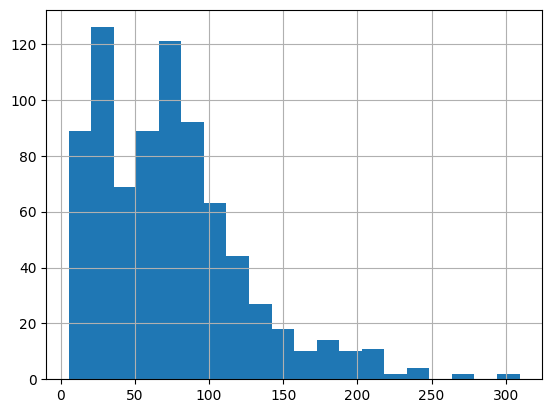

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~59070.59


<Axes: >

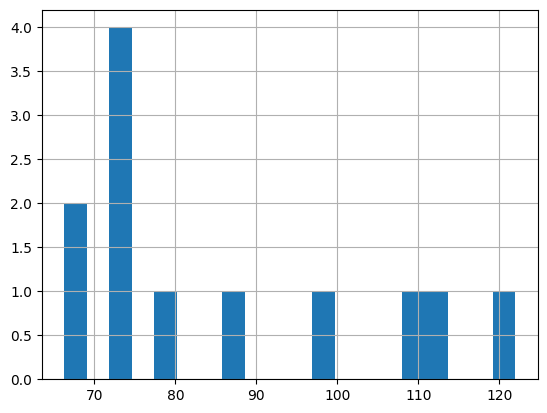

In [36]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='FSLogix']['age'].hist(bins=20)

# Completely Random Shuffle

In [37]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [38]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [39]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [40]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [41]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // 5

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [42]:
n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 793
Total card age: 59070.59


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Azure DevOps Pipelines,How do you specify a deployment environment li...,411b1e3f9a104a087416d63f6aae6a11,109.015547,102.833336,-109.015547,205.666672,0.152635,2,0,0,-109.015547
1,Azure DevOps Pipelines,How do you cache dependencies in Azure DevOps ...,df21c58e1da001e3635a6b6d964a226f,96.651125,102.833336,-109.015547,205.666672,0.152635,2,1,0,-96.651125
2,Azure Developer Associate,Application Object vs. Service Principal\n\nTh...,240f5ccd489c75b6590e5d4b28654366,40.869274,34.519000,-40.869274,172.595000,0.787660,5,0,0,-40.869274
3,Azure Developer Associate,OAuth 2.0 On-Behalf-Of Flow (OBO)\n\nUsed when...,ba3457cf401dc5e1f12c97e4a5cce754,38.706352,34.519000,-40.869274,172.595000,0.787660,5,1,0,-38.706352
4,Azure Developer Associate,Consistent Prefix (Cosmos DB Consistency)\n\nC...,0fdb11d2a79b721b51b06371266d06ae,36.883860,34.519000,-40.869274,172.595000,0.787660,5,2,0,-36.883860
5,Azure Developer Associate,Service Bus – Multicast Request/Reply Pattern\...,6349b9352fbc7652e98f1b225fdb7152,29.084657,34.519000,-40.869274,172.595000,0.787660,5,3,0,-29.084657
106,Azure Developer Associate,Lease Container (Cosmos DB Change Feed)\n\nThe...,166a656f93b250ad5f595d961dd7bd00,27.050857,34.519000,-40.869274,172.595000,0.787660,5,4,0,-27.050857
6,Terraform,Built-In Functions:\nDefinition: Terraform pro...,11db06afec8fe1222dc3a034c10f3ebe,238.086871,122.986282,-238.086871,1229.862819,0.242503,10,0,0,-238.086871
7,Terraform,"At a large organization, your centralized oper...",9dedc2f5faa2963cb9e77b1b0f536aa7,212.800922,122.986282,-238.086871,1229.862819,0.242503,10,1,0,-212.800922
107,Terraform,Double Quotes vs. Single Quotes:\n\nDouble Quo...,68d16c4a71251df4228a05244e3af837,123.464681,122.986282,-238.086871,1229.862819,0.242503,10,2,0,-123.464681



## Random

In [43]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [44]:
existing_cards.head(10)['age'].sum()

np.float64(952.6141465387049)

In [45]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
102,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,309.360453,72.920380,-309.360453,5614.869283,0.262403,77,0,0,-309.360453
86,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,305.088557,110.522199,-305.088557,5415.587729,0.664256,49,0,0,-305.088557
78,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,276.869062,114.270231,-276.869062,4342.268771,0.371360,38,0,0,-276.869062
79,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,269.080762,114.270231,-276.869062,4342.268771,0.371360,38,1,0,-269.080762
103,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,244.465888,72.920380,-309.360453,5614.869283,0.262403,77,1,0,-244.465888
50,VMWare,ESXi Shell\n\nA command-line interface (CLI) u...,29e8247f5a2aa78b7ff2123ac06ccfee,238.807379,114.845129,-238.807379,3100.818474,0.562071,27,0,0,-238.807379
6,Terraform,Built-In Functions:\nDefinition: Terraform pro...,11db06afec8fe1222dc3a034c10f3ebe,238.086871,122.986282,-238.086871,1229.862819,0.242503,10,0,0,-238.086871
46,TSQL,Q: What is the purpose of the GROUP BY clause ...,48a62cc5d988221ac8669ebbd8b27594,235.573332,115.302976,-235.573332,2767.271429,0.373065,24,0,0,-235.573332
98,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,222.960923,76.832135,-222.960923,4840.424519,0.812296,63,0,0,-222.960923
80,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,218.504891,114.270231,-276.869062,4342.268771,0.371360,38,2,0,-218.504891


In [46]:
existing_cards['age'].mean()

np.float64(74.49001919365027)